# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [113]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [114]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

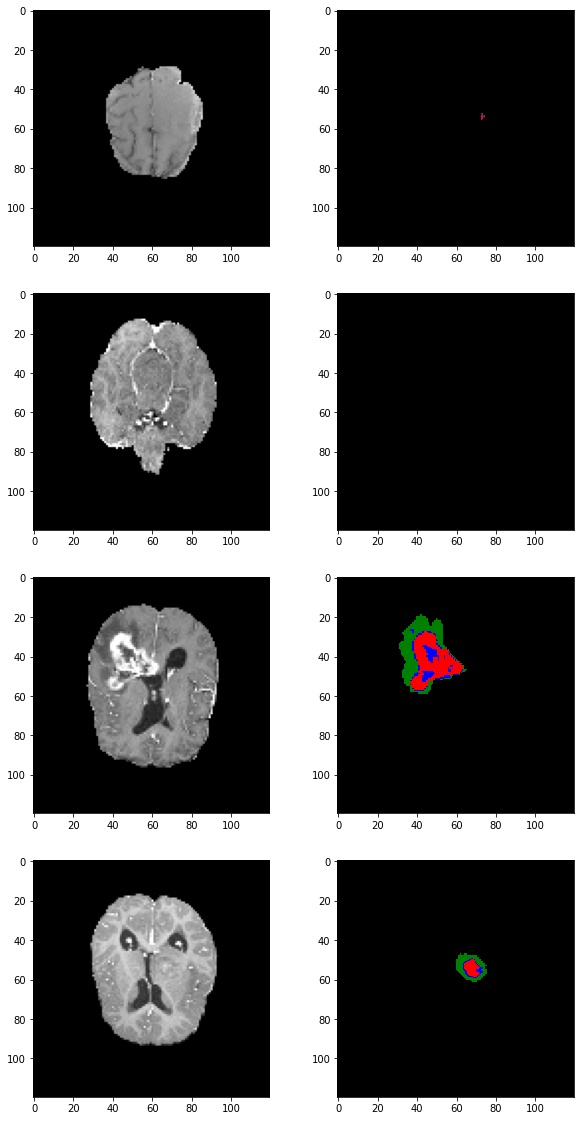

In [115]:
### Insert your code ###
training_path = "./Task01_BrainTumour_2D/training_images/"
label_path = "./Task01_BrainTumour_2D/training_labels/"
imgs = os.listdir(training_path)
random_imgs = random.sample(imgs,4)

fig, axes = plt.subplots(4,2,figsize = (10,20))

# Loop through each image and display it in grayscale format
for i in range(4):
    image = imageio.v3.imread(training_path + random_imgs[i], mode = "L")
    label_image = imageio.v3.imread(label_path + random_imgs[i], mode = "L")
    axes[i,0].imshow(image, cmap='gray')
    axes[i,1].imshow(label_image, cmap=colors.ListedColormap(["black","green","blue","red"]))

### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [116]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        indices = random.sample(range(len(self.images)), batch_size)
        images = np.array([[self.images[i]] for i in indices])
        labels = np.array([self.labels[i] for i in indices])
        return images, labels


## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [117]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )
        
        # Decoder path
        ### Insert your code ###
        
        n//=2 # 64
        self.upconv4 = nn.ConvTranspose2d(n*2, n, kernel_size=3, stride=2,padding=1, output_padding= 1)
        self.decode4 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n//=2 #32
        self.upconv3 = nn.ConvTranspose2d(n*2, n, kernel_size=3, stride=2, padding=1, output_padding= 1)
        self.decode3 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n//=2 #16
        self.upconv2 = nn.ConvTranspose2d(n*2, n, kernel_size=3, stride=2, padding=1, output_padding= 1)
        self.decode2 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        self.final = nn.ConvTranspose2d(num_filter, output_channel, kernel_size=3, stride=1,padding = 1)
        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        x = self.upconv4(x)
        x = torch.cat((x, conv3_skip), dim=1)
        x = self.decode4(x)

        x = self.upconv3(x)
        x = torch.cat((x, conv2_skip), dim=1)
        x = self.decode3(x)

        x = self.upconv2(x)
        x = torch.cat((x, conv1_skip), dim=1)
        x = self.decode2(x)
        
        x = self.final(x)
        # #x = self.final_conv(x)
        # x = self.conv_decode1(x)
        ### End of your code ###
        return x

## 4. Train the segmentation model.

In [118]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    optimizer.zero_grad()
    loss = criterion(logits, labels)
    print(loss.item())
    loss.backward()
    optimizer.step()
    ### End of your code ###

    # Evaluate
    if it % 1 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            test_loss = 0
            num_samples = 0
            batch_size = eval_batch_size
            for i in range(0, len(test_set), batch_size):
                images_batch = []
                labels_batch = []
                for j in range(batch_size):
                    if i + j < len(test_set):
                        images, labels = test_set[i + j]
                        images_batch.append(np.expand_dims(images, axis=0))
                        labels_batch.append(labels)
                if len(images_batch) > 0:
                    images_batch = np.concatenate(images_batch, axis=0)
                    images_batch = np.expand_dims(images_batch, axis=1)
                    labels_batch = np.array(labels_batch)
                    images_batch, labels_batch = torch.from_numpy(np.array(images_batch)), torch.from_numpy(labels_batch)
                    images_batch, labels_batch = images_batch.to(device, dtype=torch.float32), labels_batch.to(device, dtype=torch.long)
                    logits = model(images_batch)
                    test_loss += criterion(logits, labels_batch).item() * labels_batch.size(0)
                    num_samples += labels_batch.size(0)

            test_loss /= num_samples
            print('Test Loss: {:.4f}'.format(test_loss))
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cpu


C:\Users\Shaanu\AppData\Local\Temp\ipykernel_12156\3873090394.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, image_name))
C:\Users\Shaanu\AppData\Local\Temp\ipykernel_12156\3873090394.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_name)


1.3841267824172974
Test Loss: 1.3309
1.210303783416748
Test Loss: 1.3150
1.0637938976287842


KeyboardInterrupt: 

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

In [ ]:
### Insert your code ###
model_path = "./saved_models/model_1000.pt"
model.load_state_dict(torch.load(model_path))

training_path = "./Task01_BrainTumour_2D/training_images/"
label_path = "./Task01_BrainTumour_2D/training_labels/"
imgs = os.listdir(training_path)
random_imgs = random.sample(imgs,4)

fig, axes = plt.subplots(4,3,figsize = (10,20))

for i in range(4):
    
    image = imageio.v3.imread(training_path + random_imgs[i], mode = "L")
    original_image = imageio.v3.imread(training_path + random_imgs[i], mode = "L")
    #image = normalise_intensity(image)
    image = np.expand_dims(image, axis=0)  # Add a batch dimension
    image = np.expand_dims(image, axis=1)
    image = torch.from_numpy(image).to(device, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        logits = model(image)
        pred = logits.argmax(dim=1).squeeze().cpu().numpy()
    #pred = np.where(pred >= 0.5, 1, 0)  # Apply thresholding
    label_image = imageio.v3.imread(label_path + random_imgs[i], mode = "L")
    axes[i,0].imshow(original_image, cmap= 'gray')
    axes[i,1].imshow(pred, cmap= 'gray')#colors.ListedColormap(["black","green","blue","red"]))
    axes[i,2].imshow(label_image, cmap= colors.ListedColormap(["black","green","blue","red"]))
### End of your code ###

RuntimeError: Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "upconv1.weight", "upconv1.bias". 

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?